## Model Explainability using SHAP (Logistic Regression)

This notebook explains the behavior of the selected churn prediction model using SHAP (SHapley Additive exPlanations).
The goal is to understand why the model predicts churn risk and to validate that its behavior aligns with business intuition and EDA findings.

In [27]:
#shap analysis
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
shap.initjs()

In [28]:
# Load model & preprocessing pipeline
model = joblib.load("../../artifacts/logreg_model.pkl")
preprocessor = joblib.load("../../artifacts/preprocessor.pkl")

# Load cleaned dataset
df = pd.read_csv("../../data/processed/telco_clean.csv")

X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [30]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=feature_names
)

Logistic Regression is a linear model, so we use shap.LinearExplainer, which is computationally efficient and produces exact SHAP values.

In [31]:
explainer = shap.LinearExplainer(
    model.named_steps["classifier"],
    X_train_processed,
    feature_perturbation="interventional"
)
shap_values = explainer.shap_values(X_test_processed)


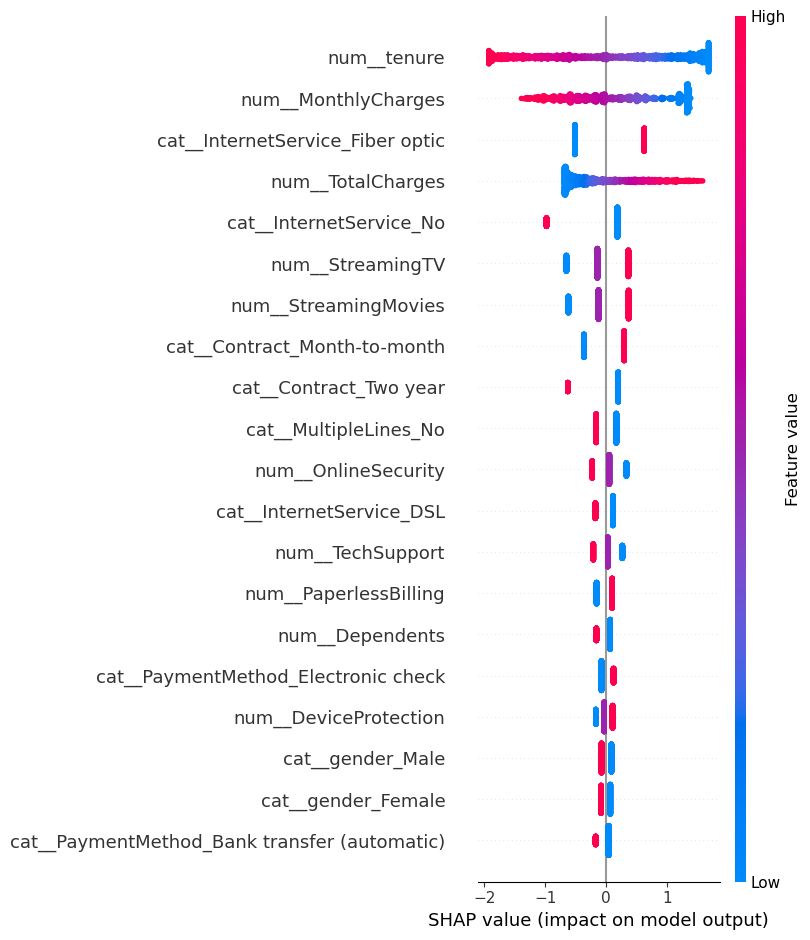

In [32]:
shap.summary_plot(
    shap_values,
    X_test_processed_df,
    plot_type="dot"
)

The summary plot shows that tenure, contract type, and monthly charges are the strongest drivers of churn risk.
Lower tenure and month-to-month contracts consistently increase churn probability.

In [33]:
coef_df = pd.DataFrame(
    model.named_steps["classifier"].coef_[0],
    index=feature_names,
    columns=["coefficient"]
).sort_values(by="coefficient")

coef_df.loc[["num__tenure", "num__MonthlyCharges"]]


,coefficient
num__tenure,-1.246478
num__MonthlyCharges,-0.832937


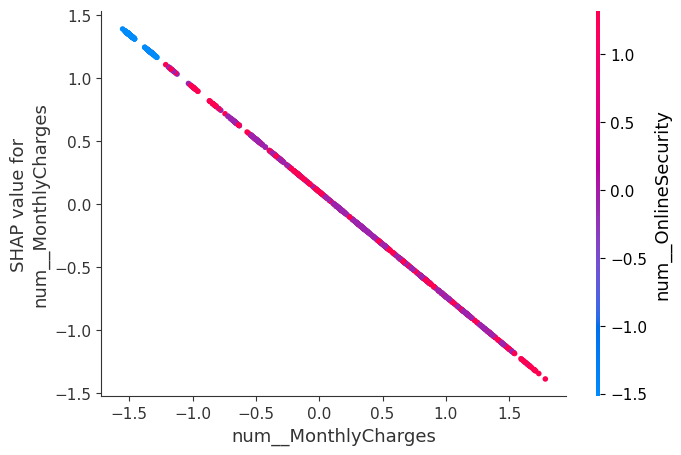

In [34]:
shap.dependence_plot(
    "num__MonthlyCharges",
    shap_values,
    X_test_processed_df
)


## Monthly Charges effect on churn contradicts from EDA

Although exploratory analysis showed a positive marginal association between MonthlyCharges and churn, SHAP analysis reveals a negative conditional effect once tenure and contract type are accounted for. This indicates that higher charges are associated with lower churn risk among otherwise comparable customers, likely reflecting greater service engagement and longer-term plans.

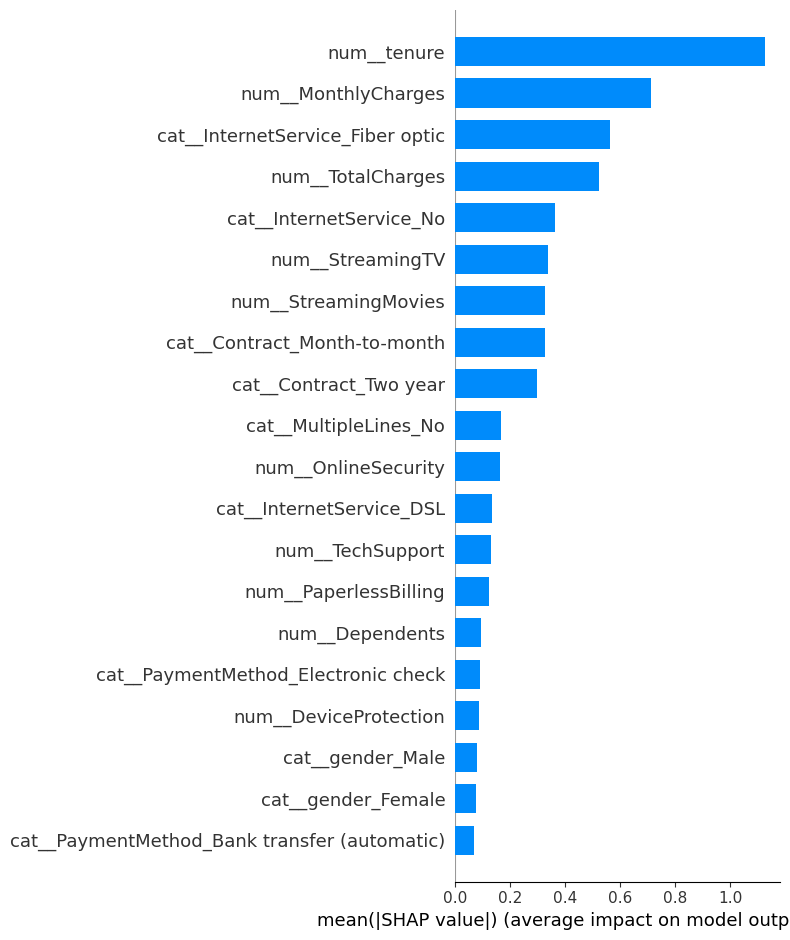

In [35]:
shap.summary_plot(
    shap_values,
    X_test_processed_df,
    plot_type="bar"
)


SHAP explanations align closely with exploratory data analysis, increasing confidence that the model has learned meaningful business patterns rather than spurious correlations.

In [36]:
y_proba = model.predict_proba(X_test)[:, 1]

high_risk_idx = np.argmax(y_proba)
low_risk_idx = np.argmin(y_proba)


In [37]:
shap.force_plot(
    explainer.expected_value,
    shap_values[high_risk_idx],
    X_test_processed_df.iloc[high_risk_idx]
)

#### This customer is predicted to have high churn risk due to short tenure, month-to-month contract, and high monthly charges.

In [38]:
shap.force_plot(
    explainer.expected_value,
    shap_values[low_risk_idx],
    X_test_processed_df.iloc[low_risk_idx]
)


#### Long tenure and a long-term contract strongly reduce churn probability for this customer.

### Key Explainability Insights

- Churn risk is driven primarily by tenure and contract structure.
- Service add-ons play a secondary but meaningful role.
- Model behavior is transparent and consistent across customers.
- Explanations are suitable for both business stakeholders and end users.

In [39]:
np.save("../../artifacts/shap_values.npy", shap_values)